# 0-1. Install Required Dependencies

For this example, we are going to use PyTorch framework.
Beforehand to use the libraries, we need to install the according libraries.

In [1]:
!pip install torch torchvision -qq

In [2]:
!pip install matplotlib seaborn scikit-learn -qq

# 1-1. Loading and Preprocessing CIFAR-10 Dataset with PyTorch
This code snippet is designed to load and preprocess the **CIFAR-10 dataset** for image classification tasks using PyTorch, a popular deep learning library.

**Transform** variable defines a series of preprocessing steps applied to the images before they are fed into a neural network.

**Training Set:** Used to train the machine learning model, allowing it to learn the patterns and features that distinguish between the different classes in the dataset.

**Testing Set:** Used to evaluate the performance of the model on new, unseen data. This helps in assessing the model's generalization ability and ensures that we measure its performance on a dataset that wasn't used during training.

**DataLoader** in PyTorch is a powerful utility that automates the process of loading the data, providing batches of images and their corresponding labels to the model during training or evaluation.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transformations for the input data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)


100%|██████████| 170498071/170498071 [00:04<00:00, 42071145.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 1-2. Adapting a Pre-trained ResNet Model for CIFAR-10

**resnet.fc.in_features:** Retrieves the number of input features from the final fully connected layer (fc) of the model. This is necessary because we need to replace the final layer to match the number of classes in our target dataset (CIFAR-10 has 10 classes), which is a preparataion for "fine-tuning"

**nn.Linear(num_ftrs, 10):** Replaces the final layer with a new fully connected layer with 10 output features, corresponding to the 10 classes of the CIFAR-10 dataset. This modification tailors the model's output to our specific classification task.  

**torch.device:** Determines the best available device for running the model. It uses a GPU (cuda:0) if one is available  

**resnet.to(device):** Moves the model to the chosen device

In [4]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import time
import copy
from tqdm import tqdm

In [5]:
# Load a pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the final layer to match the number of CIFAR-10 classes (10)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

# Move the model to the current device (GPU or CPU if GPU not exist)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.1MB/s]


# 1-3. Training the Model

In [6]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer (fine-tune the whole model)
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler (optional)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function to train and evaluate the model
def train_model(model, criterion, optimizer, scheduler, trainloader, testloader, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        dataloaders = {'train': trainloader, 'val': testloader}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for the progress bar
            data_iter = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')

            for inputs, labels in data_iter:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Optionally, update the progress bar with current batch loss
                data_iter.set_postfix(loss=loss.item(), accuracy=torch.sum(preds == labels.data).item() / inputs.size(0))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model


# Fine-tune the model
resnet = train_model(resnet, criterion, optimizer, step_lr_scheduler, trainloader, testloader, num_epochs=10)

Epoch 1/10
----------


Train Phase: 100%|██████████| 782/782 [02:04<00:00,  6.29it/s, accuracy=0.812, loss=0.506]


train Loss: 0.5397 Acc: 0.8259


Val Phase: 100%|██████████| 157/157 [00:21<00:00,  7.37it/s, accuracy=0.812, loss=0.333]


val Loss: 0.2580 Acc: 0.9116

Epoch 2/10
----------


Train Phase: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, accuracy=1, loss=0.192]     


train Loss: 0.1983 Acc: 0.9345


Val Phase: 100%|██████████| 157/157 [00:21<00:00,  7.46it/s, accuracy=0.812, loss=0.266] 


val Loss: 0.2008 Acc: 0.9296

Epoch 3/10
----------


Train Phase: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, accuracy=0.875, loss=0.335] 


train Loss: 0.1210 Acc: 0.9614


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.53it/s, accuracy=0.875, loss=0.272] 


val Loss: 0.1856 Acc: 0.9362

Epoch 4/10
----------


Train Phase: 100%|██████████| 782/782 [02:00<00:00,  6.48it/s, accuracy=0.875, loss=0.156] 


train Loss: 0.0760 Acc: 0.9777


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.51it/s, accuracy=0.875, loss=0.179] 


val Loss: 0.1754 Acc: 0.9396

Epoch 5/10
----------


Train Phase: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, accuracy=0.875, loss=0.314] 


train Loss: 0.0428 Acc: 0.9901


Val Phase: 100%|██████████| 157/157 [00:21<00:00,  7.42it/s, accuracy=0.875, loss=0.14]  


val Loss: 0.1834 Acc: 0.9407

Epoch 6/10
----------


Train Phase: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, accuracy=0.875, loss=0.324] 


train Loss: 0.0282 Acc: 0.9949


Val Phase: 100%|██████████| 157/157 [00:21<00:00,  7.39it/s, accuracy=0.875, loss=0.202] 


val Loss: 0.1866 Acc: 0.9406

Epoch 7/10
----------


Train Phase: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, accuracy=1, loss=0.0126]    


train Loss: 0.0190 Acc: 0.9973


Val Phase: 100%|██████████| 157/157 [00:21<00:00,  7.47it/s, accuracy=0.875, loss=0.203] 


val Loss: 0.1851 Acc: 0.9415

Epoch 8/10
----------


Train Phase: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, accuracy=1, loss=0.0525]    


train Loss: 0.0120 Acc: 0.9989


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.49it/s, accuracy=0.875, loss=0.201] 


val Loss: 0.1833 Acc: 0.9425

Epoch 9/10
----------


Train Phase: 100%|██████████| 782/782 [02:00<00:00,  6.49it/s, accuracy=1, loss=0.008]     


train Loss: 0.0110 Acc: 0.9991


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.53it/s, accuracy=0.875, loss=0.181] 


val Loss: 0.1838 Acc: 0.9412

Epoch 10/10
----------


Train Phase: 100%|██████████| 782/782 [02:00<00:00,  6.48it/s, accuracy=1, loss=0.0438]    


train Loss: 0.0109 Acc: 0.9991


Val Phase: 100%|██████████| 157/157 [00:21<00:00,  7.43it/s, accuracy=0.875, loss=0.195] 

val Loss: 0.1871 Acc: 0.9419

Training complete in 23m 48s
Best val Acc: 0.942500


# 1-4. Evaluate Model by Utilizing Test Dataloader and Collecting its Model Prediction Data

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation mode
resnet.eval()

# No gradient needed for evaluation
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1-5. Create Standard Confusion Matrix from the Prediction Data
This is the basic confusion matrix format we reviewed in the documentation.

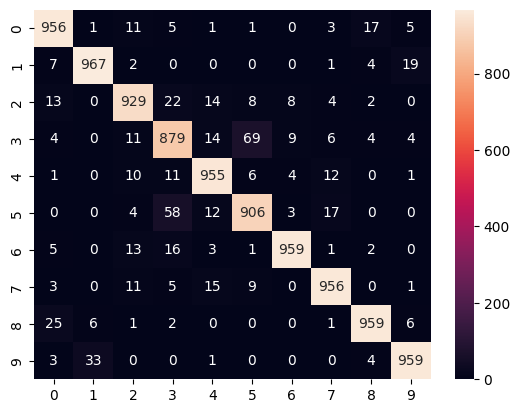

In [8]:
# Standard Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# 1-6. Normalized Confusion Matrix
***Why Normalized?***  
Using a normalized confusion matrix offers significant advantages over the standard format particularly in handling imbalanced datasets and enhancing interpretability.


*   By converting raw counts into proportions or percentages, it facilitates direct comparison across classes with varying sizes, making it **easier to measure a classifier's performance uniformly**.

*   crucial for revealing the true performance across all classes, especially when raw counts might obscure the model's effectiveness on smaller classes due to dominance by larger ones

*   **simplifies the representation**, making it more accessible for interpretation and highlighting potential model biases towards certain classes.

*   **ensures consistency when comparing models or results across different datasets** and improves visual clarity in heatmaps by standardizing the scale from 0 to 1 (or 0% to 100%)

*   aids in understanding the rate of correct and incorrect predictions more clearly but also in identifying and addressing issues related to **class imbalance** and model biases effectively.



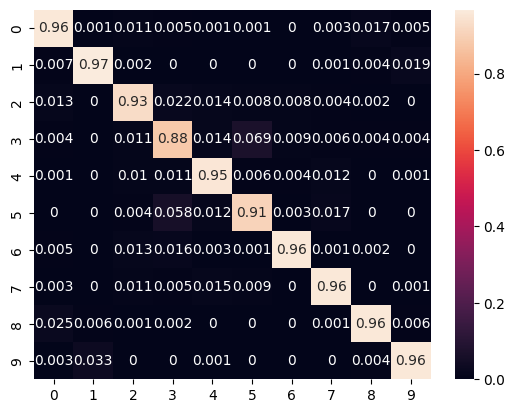

In [9]:
# Normalized Confusion Matrix
cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')
sns.heatmap(cm_normalized, annot=True)
plt.show()

# 2-1. How an Imbalanced Dataset Affects Predictions and the Confusion Matrix

This time, we will deliberately truncate data instances in certain classes of the CIFAR dataset to create an imbalanced dataset. Our objective is to observe how this imbalance affects the results of model predictions and, consequently, alters the confusion matrix.

In [11]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the original CIFAR-10 datasets
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


# 2-2. Truncate data instances of certain classes (1, 3, 5) by 90%

In [12]:
import numpy as np
from torch.utils.data import Subset

def create_imbalanced_dataset(dataset, reduce_classes, reduce_by):
    targets = np.array(dataset.targets)
    indices_to_keep = []

    for class_idx in range(10):  # CIFAR-10 has 10 classes
        indices = np.where(targets == class_idx)[0]
        if class_idx in reduce_classes:
            reduce_size = int(len(indices) * reduce_by)
            indices_to_keep.extend(indices[:reduce_size])
        else:
            indices_to_keep.extend(indices)

    imbalanced_subset = Subset(dataset, indices_to_keep)
    return imbalanced_subset

# Reduce classes 1, 3, and 5 by 90%
reduce_classes = [1, 3, 5]
reduce_by = 0.1  # Keep only 10% of the samples in the reduced classes

imbalanced_trainset = create_imbalanced_dataset(full_trainset, reduce_classes, reduce_by)
print(f"Original dataset size: {len(full_trainset)}, Imbalanced dataset size: {len(imbalanced_trainset)}")


Original dataset size: 50000, Imbalanced dataset size: 36500


# 2-3. Load the Imbalanced Dataset into Dataloader Once again

In [13]:
from torch.utils.data import DataLoader

imbalanced_trainloader = DataLoader(imbalanced_trainset, batch_size=64, shuffle=True)

# 2-4. Same Training Process

In [14]:
# Load a pre-trained ResNet model
resnet_imb = models.resnet18(pretrained=True)

# Modify the final layer to match the number of CIFAR-10 classes (10)
num_ftrs = resnet_imb.fc.in_features
resnet_imb.fc = nn.Linear(num_ftrs, 10)

# Move the model to the current device (GPU or CPU if GPU not exist)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_imb = resnet_imb.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer (fine-tune the whole model)
optimizer_imb = optim.SGD(resnet_imb.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler (optional)
step_lr_scheduler_imb = lr_scheduler.StepLR(optimizer_imb, step_size=7, gamma=0.1)

# Fine-tune the model
resnet_imb = train_model(resnet_imb, criterion, optimizer_imb, step_lr_scheduler_imb, imbalanced_trainloader, testloader, num_epochs=10)

Epoch 1/10
----------


Train Phase: 100%|██████████| 571/571 [01:29<00:00,  6.41it/s, accuracy=0.9, loss=0.249]  


train Loss: 0.5409 Acc: 0.8301


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.49it/s, accuracy=0.75, loss=0.748] 


val Loss: 0.5171 Acc: 0.8193

Epoch 2/10
----------


Train Phase: 100%|██████████| 571/571 [01:28<00:00,  6.46it/s, accuracy=0.9, loss=0.236]   


train Loss: 0.1854 Acc: 0.9413


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.53it/s, accuracy=0.875, loss=0.387]


val Loss: 0.3621 Acc: 0.8763

Epoch 3/10
----------


Train Phase: 100%|██████████| 571/571 [01:27<00:00,  6.51it/s, accuracy=0.95, loss=0.184]  


train Loss: 0.1062 Acc: 0.9687


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.54it/s, accuracy=0.875, loss=0.236]


val Loss: 0.3169 Acc: 0.8917

Epoch 4/10
----------


Train Phase: 100%|██████████| 571/571 [01:27<00:00,  6.50it/s, accuracy=1, loss=0.0302]    


train Loss: 0.0658 Acc: 0.9821


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.55it/s, accuracy=0.875, loss=0.204] 


val Loss: 0.2797 Acc: 0.9040

Epoch 5/10
----------


Train Phase: 100%|██████████| 571/571 [01:28<00:00,  6.49it/s, accuracy=1, loss=0.0519]    


train Loss: 0.0409 Acc: 0.9908


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.55it/s, accuracy=0.938, loss=0.132] 


val Loss: 0.2817 Acc: 0.9074

Epoch 6/10
----------


Train Phase: 100%|██████████| 571/571 [01:28<00:00,  6.45it/s, accuracy=0.95, loss=0.178]  


train Loss: 0.0275 Acc: 0.9948


Val Phase: 100%|██████████| 157/157 [00:21<00:00,  7.42it/s, accuracy=0.938, loss=0.156]


val Loss: 0.2983 Acc: 0.9050

Epoch 7/10
----------


Train Phase: 100%|██████████| 571/571 [01:28<00:00,  6.43it/s, accuracy=0.95, loss=0.0686] 


train Loss: 0.0198 Acc: 0.9971


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.49it/s, accuracy=0.875, loss=0.176] 


val Loss: 0.3154 Acc: 0.9044

Epoch 8/10
----------


Train Phase: 100%|██████████| 571/571 [01:28<00:00,  6.46it/s, accuracy=1, loss=0.0158]    


train Loss: 0.0126 Acc: 0.9990


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.54it/s, accuracy=0.875, loss=0.13]  


val Loss: 0.2950 Acc: 0.9090

Epoch 9/10
----------


Train Phase: 100%|██████████| 571/571 [01:28<00:00,  6.46it/s, accuracy=0.9, loss=0.0973]  


train Loss: 0.0118 Acc: 0.9992


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.57it/s, accuracy=0.938, loss=0.117] 


val Loss: 0.2958 Acc: 0.9082

Epoch 10/10
----------


Train Phase: 100%|██████████| 571/571 [01:27<00:00,  6.51it/s, accuracy=1, loss=0.0286]    


train Loss: 0.0117 Acc: 0.9990


Val Phase: 100%|██████████| 157/157 [00:20<00:00,  7.53it/s, accuracy=0.938, loss=0.1]   


val Loss: 0.2930 Acc: 0.9093

Training complete in 18m 12s
Best val Acc: 0.909300


# 2-5. Evaluate Model

In [16]:
# Evaluation mode
resnet_imb.eval()

# No gradient needed for evaluation
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_imb(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2-6. Standard Confusion Matrix

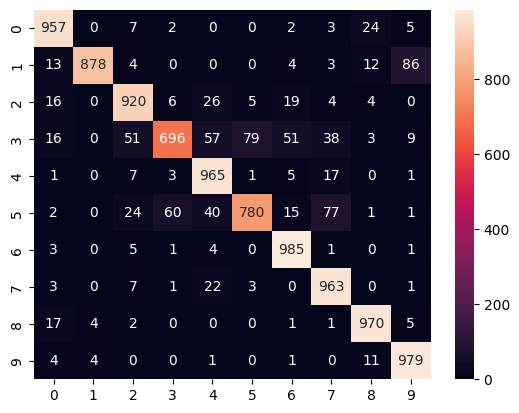

In [17]:
# Standard Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# 2-7. Normalized Confusion Matrix

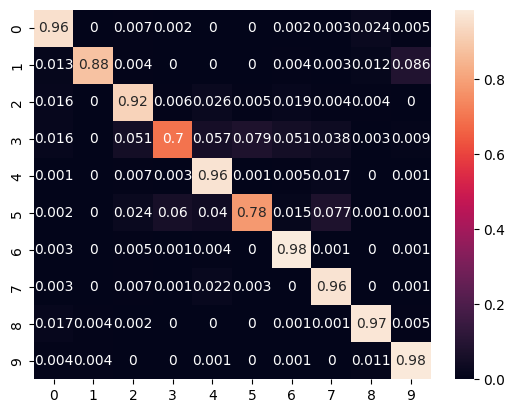

In [18]:
# Normalized Confusion Matrix
cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')
sns.heatmap(cm_normalized, annot=True)
plt.show()